<a href="https://colab.research.google.com/github/the-faisalahmed/Optimization/blob/main/Wine_Cask_Puzzle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

!pip install pyomo
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.opt import SolverStatus
import numpy as np
import pandas as pd
import itertools

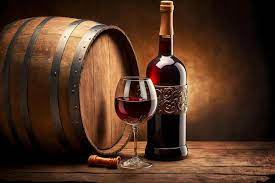

[Link](https://matmod.ch/blog/2024/01/19/wine-cask-puzzle-math09/) to the original problem here.

A farmer leaves 45 casks of wine, of which 9 each are full, three-quarters full, half full, one quarter full and empty. His five nephews want to divide the wine and the casks, without pouring wine from cask to cask, in such a way that each receives the same amount of wine and the same number of casks, and further so that each receives at least one of each kind of casks, and not two of them receive the same number of every kind of casks.

In [2]:
def SolveModel(model, solver):
  # Solve model
  opt = SolverFactory(solver)
  result = opt.solve(model)

  if (result.solver.status == SolverStatus.ok) and \
      (result.solver.termination_condition == TerminationCondition.optimal):
      # Do something when the solution in optimal and feasible
      print('Solution is Optimal')
  elif (result.solver.termination_condition == TerminationCondition.infeasible):
      # Do something when model in infeasible
      print('Solution is Infeasible')
  else:
          # Something else is wrong
      print("Solver Status:",  result.solver.status)

  # Solve time
  print('Solve Time: ', result.solver.wallclock_time)

In [112]:
model = ConcreteModel()

nephews = RangeSet(1,5)

casks = ['Full', '3/4 Full', '1/2 Full', '1/4 Full', 'Empty']
param = {'Full': 1, '3/4 Full': 3/4, '1/2 Full': 2/4, '1/4 Full': 1/4, 'Empty': 0}

model.X = Var(nephews, casks, within = NonNegativeIntegers)

# Same amount of wine per person
def con1_rule(model,i):
  return (sum(param[j]*model.X[i,j] for j in casks) == sum(param[j]*model.X[i+1,j] for j in casks))
model.con1 = Constraint(range(1,5), rule = con1_rule)

# Same number of casks per person
def con2_rule(model,i):
  return (sum(model.X[i,j] for j in casks) == sum(model.X[i+1,j] for j in casks))
model.con2 = Constraint(range(1,5), rule = con2_rule)

# Each receives at least one of each kind of casks
def con3_rule(model,i,j):
  return model.X[i,j] >= 1
model.con3 = Constraint(nephews,casks, rule = con3_rule)

# Not two of them receive the same number of every kind of casks
model.con4 = ConstraintList()
for i,k in list(itertools.combinations(nephews,2)):
  model.con4.add(expr = sum((model.X[i,j] - model.X[k,j])**2 for j in casks) >= 1)

# 9 total casks
def con5_rule(model, j):
  return sum(model.X[i,j] for i in nephews) == 9
model.con5 = Constraint(casks, rule = con5_rule)

SolveModel(model, 'bonmin')

Solution is Optimal
Solve Time:  <undefined>


In [113]:
sol = model.X.extract_values()

df = pd.Series(sol).unstack().T
df.loc['Total'] = [sum(sol[i,j]*param[j] for j in casks) for i in nephews]
df

,1,2,3,4,5
1/2 Full,3.0,2.0,1.0,1.0,2.0
1/4 Full,1.0,3.0,1.0,3.0,1.0
3/4 Full,1.0,1.0,1.0,3.0,3.0
Empty,2.0,1.0,3.0,1.0,2.0
Full,2.0,2.0,3.0,1.0,1.0
Total,4.5,4.5,4.5,4.5,4.5
